In [1]:
import matplotlib.pyplot as plt
import xdem
import numpy as np
import geoutils as gu
from matplotlib_scalebar.scalebar import ScaleBar
from rasterio.mask import mask
import geopandas as gpd
from rasterio.windows import from_bounds
import math

import rioxarray as rioxr
from rasterio.plot import show
import rasterio as rio
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.patches as mpatches  

In [2]:
# List of all the DEM files
ddem = xdem.DEM(r"D:\ANPDEM\ANPDEMcoreg_ddempostNOV024.tif")
#ddem = xdem.DEM(r"D:\ANPddemfilledwithregional2024.tif")

print("dDEM Reference: " + str(ddem.crs))
print("Nodata vale: " + str(ddem.nodata))
print(f"Pixel dimensions: {ddem.res}")


reference_dem = xdem.DEM(r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\Catalyst June 2023\Reference\ARCTICDEMmerged_dem.tif")
print("Reference Coordinate Reference: " + str(reference_dem.crs))
print("Nodata vale: " + str(reference_dem.nodata))
print(f"Pixel dimensions: {reference_dem.res}")

dDEM Reference: EPSG:32620
Nodata vale: nan
Pixel dimensions: (4.0, 4.0)
Reference Coordinate Reference: EPSG:3413
Nodata vale: -9999.0
Pixel dimensions: (2.0, 2.0)


In [3]:
ddem.data = xdem.filters.distance_filter(ddem.data, radius=30, outlier_threshold=10)
#Filter out pixels whose value is distant more than a set threshold from the average value of all neighbor pixels within a given radius.

In [4]:
# Define the glacier name
glaciername= "Turner"

# Define the error values
core_error = 21.98 # Coregistration error in meters (NMAD)
area_error_km2 = 0.08  # km²

# List of all the shapefiles
outlines_1960 = gu.Vector(rf"D:\All_outline\{glaciername}1960.shp")
outlines_2023 = gu.Vector(rf"D:\All_outline\{glaciername}2023.shp")

# Load the centerlines
cls_smooth2023 = gpd.read_file(rf"D:\outputs\{glaciername}2023_Centerlines_smooth.shp")
cls_smooth1960 = gpd.read_file(rf"D:\outputs\{glaciername}1960_Centerlines_smooth.shp") 

#outlines_1960 = gu.Vector(r"D:\All_outline\Caribou1960.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Fork1960.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Nakarpog1960.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Nerutusoq1960.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Norman1960.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Turner1960.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Rundle1959_Project.shp")
#outlines_1960 = gu.Vector(r"D:\All_outline\Highway1960.shp")
#outlines_1960 = gu.Vector(outlines_1960.ds.to_crs(ddem.crs))

#outlines_2023 = gu.Vector(r"D:\All_outline\Caribou2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Fork2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Nakarpog2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Nerutusoq2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Norman2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Rundle2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Turner2023.shp")
#outlines_2023 = gu.Vector(r"D:\All_outline\Highway2023.shp")
#outlines_2023 = gu.Vector(outlines_2023.ds.to_crs(ddem.crs))


In [5]:
# Reproject the outlines to the same CRS as ddem
outlines_1960 = gu.Vector(outlines_1960.ds.to_crs(ddem.crs))
outlines_2023 = gu.Vector(outlines_2023.ds.to_crs(ddem.crs))

In [6]:
reference_dem = xdem.DEM(reference_dem).reproject(ddem, resampling='bilinear')
reference_dem.nodata = np.nan

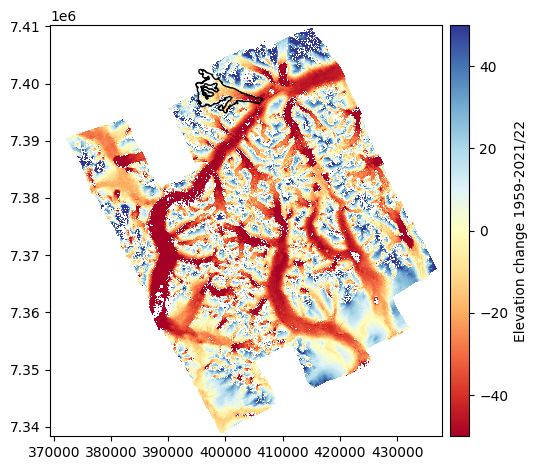

In [7]:
ax = plt.subplot()
outlines_1960.ds.plot(ax=ax, facecolor='none', edgecolor='k', zorder=2)
ddem.plot(ax=ax, cmap='RdYlBu', vmin=-50, vmax=50, cbar_title='Elevation change 1959-2021/22', zorder=1)
plt.tight_layout()
plt.show()

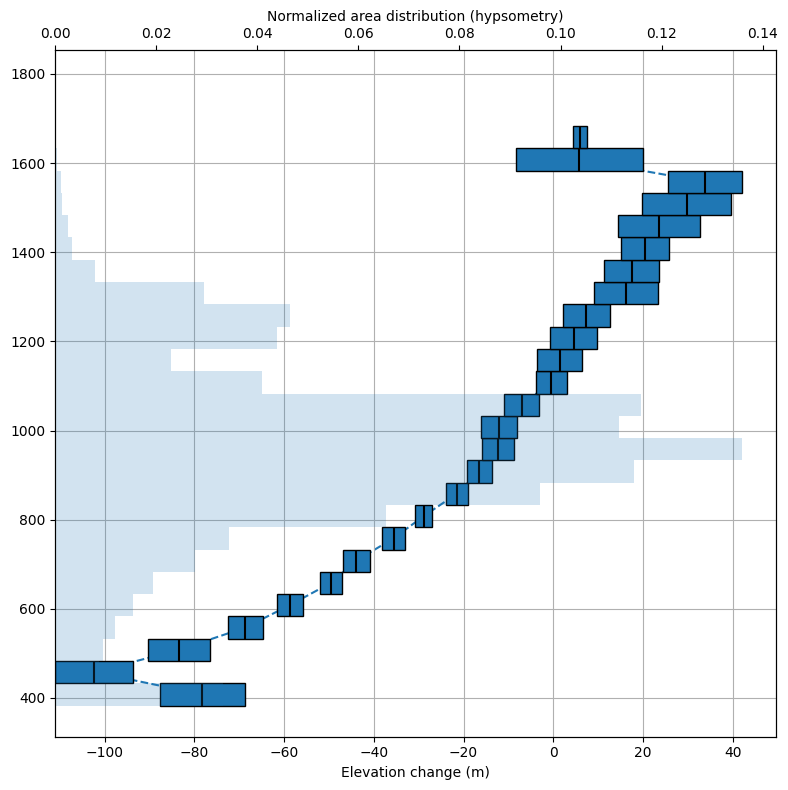

In [8]:
# Create a mask for the selected glacier
mask = outlines_1960.create_mask(ddem)
mask = mask.data
ddem_post = ddem.copy()

# Perform hypsometric binning
ddem_bins = xdem.volume.hypsometric_binning(ddem_post[mask], reference_dem[mask])
stds = xdem.volume.hypsometric_binning(ddem_post[mask], reference_dem[mask], aggregation_function=np.std)

plt.figure(figsize=(8, 8))
plt.grid(zorder=0)

# Plot the mean elevation change
plt.plot(ddem_bins["value"], ddem_bins.index.mid, linestyle="--", zorder=1)

# Plot the standard deviation of the elevation change
plt.barh(
    y=ddem_bins.index.mid,
    width=stds["value"],
    left=ddem_bins["value"] - stds["value"] / 2,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    edgecolor="black",
)

# Add vertical lines at the mean elevation change
for bin in ddem_bins.index:
    plt.vlines(ddem_bins.loc[bin, "value"], bin.left, bin.right, color="black", zorder=3)

plt.xlabel("Elevation change (m)")
plt.twiny()

# Plot the normalized area distribution (hypsometry)
plt.barh(
    y=ddem_bins.index.mid,
    width=ddem_bins["count"] / ddem_bins["count"].sum(),
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
plt.xlabel("Normalized area distribution (hypsometry)")
plt.ylabel("Elevation (m a.s.l.)")
plt.tight_layout()
plt.show()  

Text(0.5, 0, 'Glacier area per elevation bins (km²)')

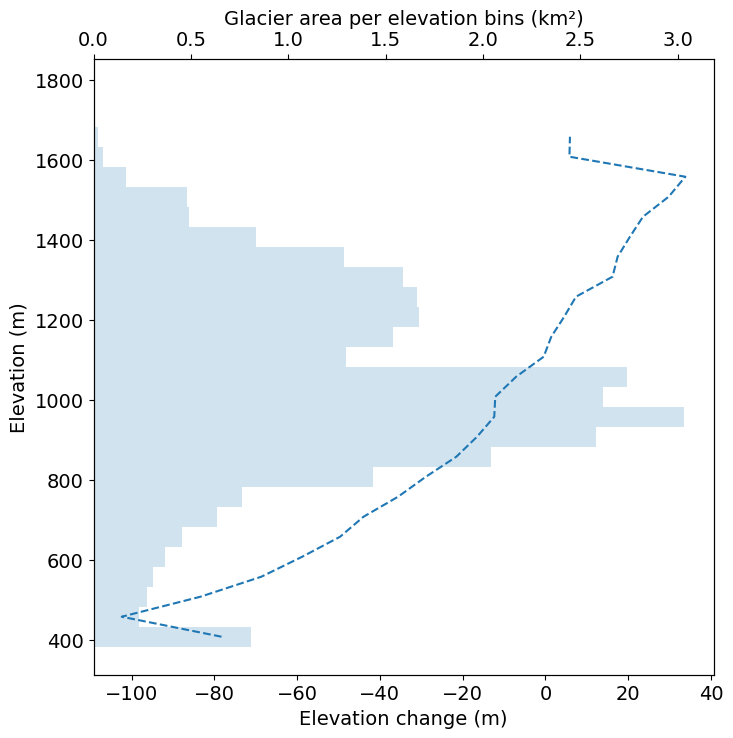

In [9]:
bins_area = xdem.volume.calculate_hypsometry_area(ddem_bins, reference_dem[mask], pixel_size=ddem.res)

plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 8))
plt.plot(ddem_bins["value"], ddem_bins.index.mid, linestyle="--", zorder=1)
plt.xlabel("Elevation change (m)")
plt.ylabel("Elevation (m)")

plt.twiny()
plt.barh(
    y=ddem_bins.index.mid,
    width=bins_area/1e6,
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
plt.xlabel("Glacier area per elevation bins (km\u00b2)")

In [10]:
# Calculate the elevation change using local hypsometric interpolation
ddem_filled = xdem.volume.local_hypsometric_interpolation( 
    voided_ddem=ddem_post.data, 
    ref_dem=reference_dem.data,
    mask=mask
)

In [11]:
ddem_filled = xdem.DEM.from_array(ddem_filled, transform=ddem.transform, crs=ddem.crs)

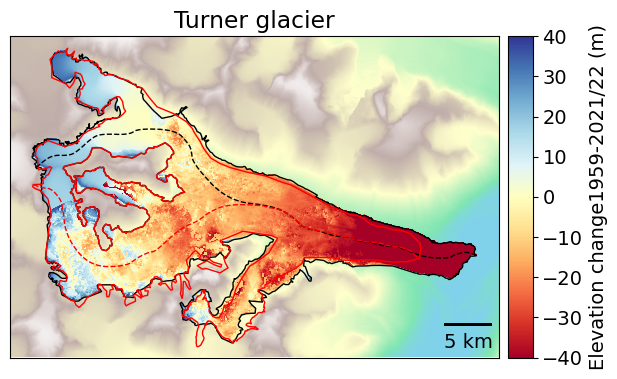

In [12]:
# Ensure the CRS matches other spatial data
cls_smooth2023 = cls_smooth2023.to_crs(ddem_filled.crs)
cls_smooth1960 = cls_smooth1960.to_crs(ddem_filled.crs)

# Plotting the outlines
fig, ax = plt.subplots()
outlines_1960.ds.plot(ax=ax, facecolor='none', edgecolor='k', zorder=2)
outlines_2023.ds.plot(ax=ax, facecolor='none', edgecolor='r', zorder=3)

# Plotting the DEM data using `imshow()`
ddem_filled.plot(ax=ax, cmap='RdYlBu', vmin=-40, vmax=40, cbar_title='Elevation change1959-2021/22 (m)', zorder=1, add_cbar= True)
reference_dem.plot(ax=ax, cmap='terrain', zorder=0, alpha=0.5, add_cbar= False)

# Plotting the centerlines
cls_smooth1960.plot(ax=ax, color='black', zorder=4, linewidth=1, linestyle='--')  
cls_smooth2023.plot(ax=ax, color='red', zorder=4, linewidth=1, linestyle='--')  

# Other configurations
ax.set_title(f'{glaciername} glacier')
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
bounds = outlines_1960.ds.total_bounds
buffer_size = 0.05   # This will add a 5% buffer around the outline
x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]
ax.set_xlim([bounds[0] - buffer_size * x_range, bounds[2] + buffer_size * x_range])
ax.set_ylim([bounds[1] - buffer_size * y_range, bounds[3] + buffer_size * y_range])
plt.tight_layout()

# Creating the scalebar object
# Get the pixel size in meters from the DEM data
pixel_size = ddem_filled.res[0]  # Assuming the pixel size is the same in x and y direction

# Creating the scalebar object
scalebar = ScaleBar(dx=pixel_size, location='lower right', length_fraction=0.15, height_fraction=0.01, frameon=False)
ax.add_artist(scalebar)
plt.show()

In [13]:
ddem_bins = xdem.volume.hypsometric_binning(ddem_filled[mask], reference_dem[mask])
bins_area = xdem.volume.calculate_hypsometry_area(ddem_bins, reference_dem[mask], pixel_size=ddem_filled.res)

In [14]:
# Create a mask for the selected glacier
mask = outlines_1960.create_mask(ddem_filled)
mask = mask.data

# Calculate the sum of the elevation values in the masked filled DEM
sum_elevation_filled_ddem = np.nansum(ddem_filled[mask])

print(f"Sum of elevation in the filled dDEM: {sum_elevation_filled_ddem:.2f} m")

Sum of elevation in the filled dDEM: -21043402.00 m


In [15]:
# Calculate the sum of the elevation values in the masked filled DEM
mean_elevation_filled_ddem = np.nanmean(ddem_filled[mask])

print(f"Mean of elevation in the filled dDEM: {mean_elevation_filled_ddem:.2f} m")

Mean of elevation in the filled dDEM: -11.47 m


In [16]:
# Given values for uncertainty and mass balance calculations
years = 61.5  # years (1959-2021/22)
density = 850  # kg/m³
density_error = 60  # kg/m³
pixel_area = 4 * 4  # m²

# Derived values
area_error = area_error_km2 * 1e6  # m²
total_value_area = np.sum(bins_area) # m²
total_value_elevation = sum_elevation_filled_ddem # m

# Calculate the number of pixels
number_of_pixels = total_value_area / pixel_area

# Calculate the uncertainty per pixel (only random error considered)
uncertainty_per_pixel = core_error

# Calculate the total uncertainty for the summed elevation
total_uncertainty = uncertainty_per_pixel * math.sqrt(number_of_pixels)
total_uncertainty * pixel_area  # m³

# Volume and mass calculations
volume = total_value_elevation * pixel_area  # m³
volume_error = np.sqrt((core_error / total_value_elevation)**2 + ( area_error/ total_value_area)**2) * volume 

mass = density * volume  # kg
mass_error = np.sqrt((density_error / density)**2 + (volume_error / volume)**2) * mass  # kg

# Convert mass to water equivalent (m w.e.)
mass_w_eq = mass / 1000  # m w.e.
mass_error_w_eq = mass_error / 1000  # m w.e.

# Specific Mass Balance
specific_mass_balance = mass_w_eq / total_value_area  # kg/m² In Water Equivalent (m w.e.)  ( ρwater=1000kg/m³)
specific_mass_balance_error = np.sqrt((mass_error_w_eq / mass_w_eq)**2 + (area_error / total_value_area)**2) * specific_mass_balance  # kg/m²

# Annual Specific Mass Balance
annual_specific_mass_balance = specific_mass_balance / years  # kg/m²/year
annual_specific_mass_balance_error = specific_mass_balance_error / years  # kg/m²/year

# Print results
print(f"Number of Pixels: {number_of_pixels}")
print(f"Uncertainty per Pixel: {uncertainty_per_pixel:.2f} m")
print(f"Sum of Δ H dDEM: {total_value_elevation:.2f} ± {total_uncertainty:.2f} m")
print(f"Volume: {volume:.2f} ± {volume_error:.2f} m³")
print(f"Mass: {mass:.2f} ± {mass_error:.2f} kg")
print(f"Specific Mass Balance: {specific_mass_balance:.2f} ± {specific_mass_balance_error:.2f} m w.e.")
print(f"Annual Specific Mass Balance: {annual_specific_mass_balance:.2f} ± {annual_specific_mass_balance_error:.2f} m w.e. a⁻¹")

Number of Pixels: 1836133.0
Uncertainty per Pixel: 21.98 m
Sum of Δ H dDEM: -21043402.00 ± 29783.78 m
Volume: -336694432.00 ± -916857.48 m³
Mass: -286190267200.00 ± -20216692593.46 kg
Specific Mass Balance: -9.74 ± -0.69 m w.e.
Annual Specific Mass Balance: -0.16 ± -0.01 m w.e. a⁻¹


C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_27260\2284922519.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axs[0].legend(loc='upper right')


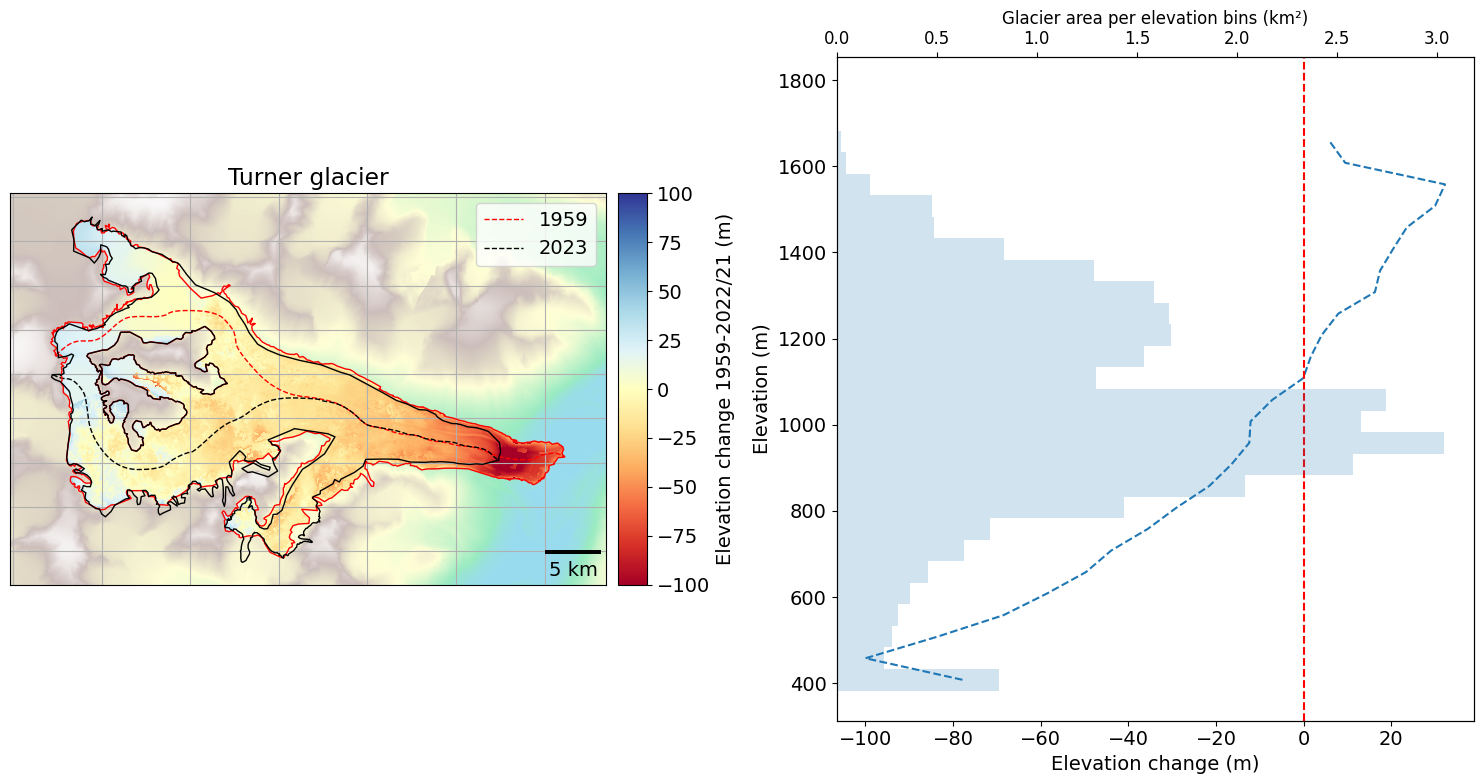

In [17]:
# Ensure the CRS matches other spatial data
cls_smooth2023 = cls_smooth2023.to_crs(ddem_filled.crs)
cls_smooth1960 = cls_smooth1960.to_crs(ddem_filled.crs)

# Initialize the plot with 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))  

# Plot 1
axs[0].imshow(ddem_filled.data, cmap='Greys', zorder=5)
outlines_1960.ds.plot(ax=axs[0], facecolor='none', edgecolor='r', zorder=3, label='Outline 1959')
outlines_2023.ds.plot(ax=axs[0], facecolor='none', edgecolor='k', zorder=3, label='Outline 2022')
ddem_filled.plot(ax=axs[0], cmap='RdYlBu', vmin=-100, vmax=100, cbar_title='Elevation change 1959-2022/21 (m)', zorder=1)
cls_smooth1960.plot(ax=axs[0], color='red', zorder=2, linewidth=1, linestyle='--', label='1959')  
cls_smooth2023.plot(ax=axs[0], color='black', zorder=2, linewidth=1, linestyle='--', label='2023')  
reference_dem.plot(ax=axs[0], cmap='terrain', zorder=0, alpha=0.4, add_cbar= False)

# Add title and labels
axs[0].set_title(f'{glaciername} glacier')

# Remove ticks
axs[0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# Set plot limits with a buffer
bounds = outlines_1960.ds.total_bounds
buffer_size = 0.08   
x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]
axs[0].set_xlim([bounds[0] - buffer_size * x_range, bounds[2] + buffer_size * x_range])
axs[0].set_ylim([bounds[1] - buffer_size * y_range, bounds[3] + buffer_size * y_range])

# Add scale bar, grid, legend
pixel_size = ddem_filled.res[0]
scalebar = ScaleBar(dx=pixel_size, location='lower right', length_fraction=0.15, height_fraction=0.01, frameon=False)
axs[0].add_artist(scalebar)
axs[0].grid(True)
axs[0].legend(loc='upper right')

# Plot 2
plt.rcParams['font.size'] = 12
axs[1].plot(ddem_bins["value"], ddem_bins.index.mid, linestyle="--", zorder=1)
axs[1].set_xlabel("Elevation change (m)")
axs[1].set_ylabel("Elevation (m)")
axs[1].axvline(x=0, color='red', linestyle='--', zorder=3)

# Create a twin Axes sharing the y-axis
ax2 = axs[1].twiny()
ax2.barh(
    y=ddem_bins.index.mid,
    width=bins_area/1e6,
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
ax2.set_xlabel("Glacier area per elevation bins (km\u00b2)")

# Show the plot
plt.tight_layout()
plt.show()

c:\Users\WilsonSIRL5-MCY-E113\miniconda3\envs\xdem\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


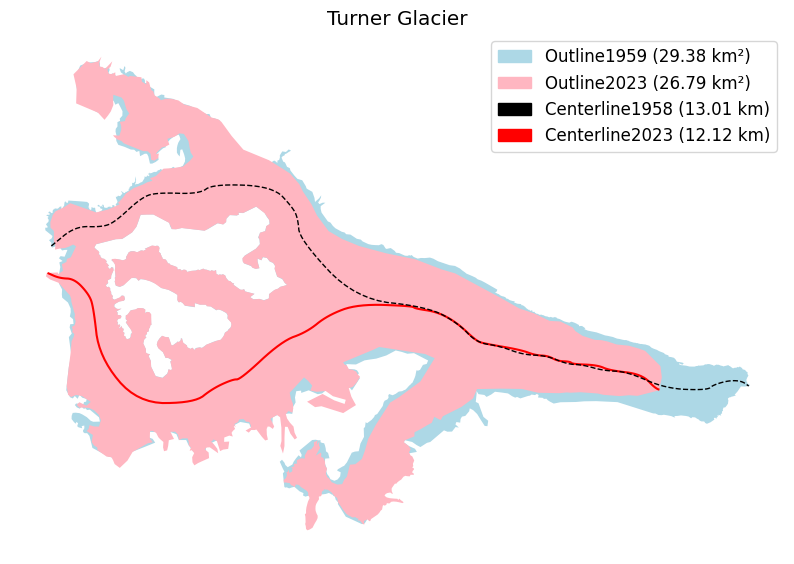

In [18]:
# Read the shapefiles
new_cls_smooth = cls_smooth2023
old_cls_smooth = cls_smooth1960

# Calculate the area extent
old_area = outlines_1960.to_crs({'init': 'epsg:32620'}).area.sum() / 10**6
new_area = outlines_2023.to_crs({'init': 'epsg:32620'}).area.sum() / 10**6

# Calculate the length of the centerlines in km
new_cls_length = new_cls_smooth.geometry.length.sum() / 1000
old_cls_length = old_cls_smooth.geometry.length.sum() / 1000

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plot the old outline in light blue
outlines_1960.ds.plot(ax=ax, facecolor='lightblue')

# Plot the new outline in red
outlines_2023.ds.plot(ax=ax, facecolor='lightpink')

# Plot the centerlines
new_cls_smooth.plot(ax=ax, color='red')
old_cls_smooth.plot(ax=ax, color='black', linewidth=1, linestyle='--')

# Create legend handles manually
handles = [
    mpatches.Patch(color='lightblue', label=f'Outline1959 ({old_area:.2f} km²)'),
    mpatches.Patch(color='lightpink', label=f'Outline2023 ({new_area:.2f} km²)'),
    mpatches.Patch(color='black', label=f'Centerline1958 ({old_cls_length:.2f} km)'),
    mpatches.Patch(color='red', label=f'Centerline2023 ({new_cls_length:.2f} km)')
]


plt.title(f'{glaciername} Glacier')
# Hide the ticks and labels on both axes
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# Add a legend at the bottom left
plt.legend(handles=handles, loc='upper right', prop={'size': 12})

# Show the plot
plt.show()
